## PTA w/ 2D SFS

The new PTA 2D jMSFS and all 2D simulation code are in the PTA repo `master` branch. Install:

```
conda create -n pta python=3.9           ## <- It has to be python 3.9
conda activate pta
conda install -c conda-forge -c bioconda -c PTA pta
```

This notebook demonstrates the API interface, but you can also run 2D sims from the command line:

```
# Create a new 2D params file
$> PTA -m 2D_Temporal -n my2d-sims
# Run 10 simulations (-s) in parallel on 10 cores (-c)
$> PTA -p params-my2d-sims.txt -s 10 -c 10
```

In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import glob
import matplotlib.pyplot as plt
import math
import msprime
import numpy as np
import pandas as pd
import PTA

pd.set_option('display.max_columns', None)

from IPython.display import SVG, display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
sim = PTA.DemographicModel_2D_Temporal("2D-test")
print(sim.get_params())

------- PTA params - DemographicModel_2D_Temporal - (v.0.0.11) -----------------
2D-test              ## [0] [simulation_name]: The name of this simulation scenario
./default_PTA        ## [1] [project_dir]: Where to save files
10                   ## [2] [npops]: Number of populations undergoing co-demographic processes
4,4                  ## [3] [nsamps]: Numbers of samples for each populations
0                    ## [4] [zeta]: Proportion of coexpanding taxa. Default will sample U~(0, 1)
1000                 ## [5] [length]: Length in bp of each independent genomic region to simulate
100                  ## [6] [num_replicates]: Number of genomic regions to simulate
1                    ## [7] [generation_time]: Generation time in years
1e-09                ## [8] [recoms_per_gen]: Recombination rate within independent regions scaled per base per generation
1e-08                ## [9] [muts_per_gen]: Mutation rate scaled per base per generation
80                   ## [10] [t_rece

## Modify some parameters

In [3]:
sim.set_param("npops", 4)                       # Number of co-distributed population pairs
sim.set_param("nsamps", [3,2])                  # Historical and contemporary sample size (in diploid individuals)
sim.set_param("num_replicates", 10)             # Number of independent genomic regions to simulate (# loci)
sim.set_param("muts_per_gen", 0.0000001)        # Obvious
sim.set_param("generation_time", 3)             # Obvious
sim.set_param("ne_ancestral", [10000,1000000])  # Set a prior range on ne_ancestral
print(sim.get_params())

------- PTA params - DemographicModel_2D_Temporal - (v.0.0.11) -----------------
2D-test              ## [0] [simulation_name]: The name of this simulation scenario
./default_PTA        ## [1] [project_dir]: Where to save files
4                    ## [2] [npops]: Number of populations undergoing co-demographic processes
3,2                  ## [3] [nsamps]: Numbers of samples for each populations
0                    ## [4] [zeta]: Proportion of coexpanding taxa. Default will sample U~(0, 1)
1000                 ## [5] [length]: Length in bp of each independent genomic region to simulate
10,10,10,10          ## [6] [num_replicates]: Number of genomic regions to simulate
3.0                  ## [7] [generation_time]: Generation time in years
1e-09                ## [8] [recoms_per_gen]: Recombination rate within independent regions scaled per base per generation
1e-07                ## [9] [muts_per_gen]: Mutation rate scaled per base per generation
80                   ## [10] [t_rece

## Run one 2d simulation to capture the results

In [4]:
my_jmsfs = sim.serial_simulate(nsims=1)

  [####################] 100%  Finished 1 simulations in   0:00:00 | 
 

## Take the first jMSFS and plot the average per bin across all species

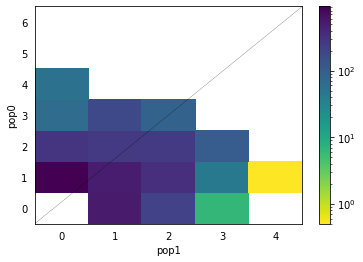

In [7]:
my_jmsfs[0].plot_2d_sfs()

## Run several simulations

In [94]:
!rm ./default_PTA/2D-test-SIMOUT.csv
sim.simulate(nsims=1000)

    Generating 1000 simulation(s).
  [####################] 100%  Finished 1000 simulations in   0:00:31
 

## Simulation results are written to a file

In [54]:
!head -n 2 ./default_PTA/2D-test-SIMOUT.csv

zeta zeta_e r_moderns_mean r_moderns_std r_moderns_skewness r_moderns_kurtosis r_moderns_median r_moderns_iqr Ne_s_mean Ne_s_std Ne_s_skewness Ne_s_kurtosis Ne_s_median Ne_s_iqr 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139
0.215 1 0.000 0.000 0.000 -3.000 0.000 0.000 243871.554 95117.954 0.577 -0.943 224570.673 80379.885 0.000 355.500 99.000 105.000 49.000 825.500 286.500 119.500 864.500 11.000 344.500 157.500 102.500 165.000 0.000 60.500 330.500 243.000 0.000 0.000 39.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 289.500 68.500 13.500 0.000

## They can also be loaded back in and reformatted nicely for analysis

In [95]:
params, jmsfs = sim.load_simulations()
print(len(jmsfs))
params.head()

1000


,zeta,zeta_e,r_moderns_mean,r_moderns_std,r_moderns_skewness,r_moderns_kurtosis,r_moderns_median,r_moderns_iqr,Ne_s_mean,Ne_s_std,Ne_s_skewness,Ne_s_kurtosis,Ne_s_median,Ne_s_iqr
0,0.225,1,0.0,0.0,0.0,-3.0,0.0,0.0,358377.825,252269.550,0.227,-1.024,338769.445,228311.756
1,0.306,2,0.0,0.0,0.0,-3.0,0.0,0.0,164354.344,147496.934,0.286,-1.616,135422.804,241304.794
2,0.918,4,0.0,0.0,0.0,-3.0,0.0,0.0,376412.025,142812.901,-0.820,-0.900,421939.931,138175.568
3,0.312,2,0.0,0.0,0.0,-3.0,0.0,0.0,74413.308,91653.311,1.152,-0.669,23149.243,57423.241
4,0.761,4,0.0,0.0,0.0,-3.0,0.0,0.0,178215.235,157090.487,0.317,-1.551,148495.130,247141.643


In [18]:
print(params.iloc[0], jmsfs[0])

zeta                       0.924
zeta_e                     4.000
r_moderns_mean             0.000
r_moderns_std              0.000
r_moderns_skewness         0.000
r_moderns_kurtosis        -3.000
r_moderns_median           0.000
r_moderns_iqr              0.000
Ne_s_mean             100000.000
Ne_s_std                   0.000
Ne_s_skewness              0.000
Ne_s_kurtosis             -3.000
Ne_s_median           100000.000
Ne_s_iqr                   0.000
Name: 0, dtype: float64 [[[  0.  177.   39.    1.    0. ]
  [310.   89.  325.   80.5  76.5]
  [ 86.5 129.5  92.   55.    0. ]
  [ 35.  153.   74.5   0.    0. ]
  [ 15.    0.    0.    0.    0. ]
  [  0.    0.    0.    0.    0. ]
  [  0.    0.    0.    0.    0. ]]

 [[  0.  173.   30.5   1.    0. ]
  [303.5  83.5  45.   25.    1. ]
  [ 50.5 120.5  36.5  37.5   0. ]
  [ 14.   70.5  67.    0.    0. ]
  [ 13.5   0.    0.    0.    0. ]
  [  0.    0.    0.    0.    0. ]
  [  0.    0.    0.    0.    0. ]]

 [[  0.  117.   16.5   0.5   0. ]


# Plot all simulated jMSFS collapsed into PC-space
The `color_by` argument allows you to color the points by a specific parameter column (see previous cell for options).

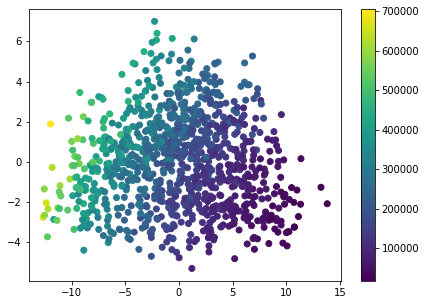

In [102]:
ax = sim.plot_sims_PCA(color_by="Ne_s_mean")

(140,)